<a href="https://colab.research.google.com/github/MrCharli03/RL_BFRRCE/blob/main/Estudio_FrozenLake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Instalacion de librerias necesarias
!pip install gymnasium

# Instalación de algunos paquetes.
!apt-get update

# Para visualizar en colab https://medium.com/@coldstart_coder/visually-rendering-python-gymnasium-in-jupyter-notebooks-4413e4087a0f
!apt-get install -y python-opengl ffmpeg
!apt-get install --upgrade cmake

# Para usar gymnasium[box2d]
!apt install swig xvfb
!pip install -U  pyvirtualdisplay


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,369 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [56.4 kB]
Get:13 https://r2u.stat.illinois.edu/

In [2]:
#@title Importación de librerias

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import re
import io
import base64
from IPython import display
from IPython.display import HTML
from pyvirtualdisplay import Display
from tqdm import tqdm

SEMILLA

In [3]:
import os
import gc
import torch
import numpy as np
import gymnasium as gym

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

# Depuración de errores en CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Muestra errores de CUDA en el punto exacto donde ocurren

# Configuración de la semilla para reproducibilidad
seed = 2024 # Se define una semilla fija

# Fijar la semilla en NumPy
np.random.seed(seed) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(seed) # Establece una instancia del generador de NumPy con la misma semilla

# Fijar la semilla en Python
os.environ['PYTHONHASHSEED'] = str(seed) # Evita variabilidad en hashing de Python

# Fijar la semilla en PyTorch
torch.manual_seed(seed) # Asegura resultados reproducibles en operaciones de PyTorch

if torch.cuda.is_available(): # Si hay GPU disponible
    torch.cuda.manual_seed(seed) # Fija la semilla para la GPU
    torch.backends.cudnn.deterministic = True # Hace las operaciones de CUDNN determinísticas
    torch.backends.cudnn.benchmark = False # Desactiva optimizaciones de CUDNN para evitar variabilidad

Usando dispositivo: cuda


# Declaracion de entornos

In [4]:
#@title Importamos el Taxi
name = 'FrozenLake-v1'

# Creamos el entorno Taxi-v3
env = gym.make(name, render_mode="rgb_array")

#Funciones para representar las graficas

In [5]:
#@title Funcion para mostrar los episodios
def plot_episode_lengths(episode_lengths, window_size=10):
    # Convertir a array por si acaso
    episode_lengths = np.array(episode_lengths)

    # Ajustar una regresión lineal a los datos
    x = np.arange(len(episode_lengths))
    coefficients = np.polyfit(x, episode_lengths, 1)  # Regresión lineal (grado 1)
    trend_line = np.polyval(coefficients, x)  # Calcular la línea de tendencia

    plt.figure(figsize=(8, 4))
    plt.plot(episode_lengths, label="Longitud del episodio", alpha=0.5)
    # Graficar la línea de tendencia en lugar de la media móvil
    plt.plot(x, trend_line, label="Línea de tendencia", color='red')
    plt.xlabel("Episodio")
    plt.ylabel("Longitud")
    plt.title("Evolución de la longitud de los episodios")
    plt.grid(True)
    plt.legend()
    plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot(list_stats, window_size=10):
    indices = list(range(len(list_stats)))

    # Convertir a array para asegurar el correcto manejo
    list_stats = np.array(list_stats)

    # Ajustar una regresión lineal a los datos
    x = np.arange(len(list_stats))
    coefficients = np.polyfit(x, list_stats, 1)  # Regresión lineal (grado 1)
    trend_line = np.polyval(coefficients, x)  # Calcular la línea de tendencia

    plt.figure(figsize=(8, 4))
    plt.plot(indices, list_stats, label='Proporción de recompensas', alpha=0.5)
    plt.plot(x, trend_line, label="Línea de tendencia", color='red')  # Graficar la línea de tendencia
    plt.title('Proporción de recompensas')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.grid(True)
    plt.legend()
    plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison(list_stats_on, list_stats_off, window_size=10):
    # Convertir a arrays para garantizar el correcto manejo de datos
    list_stats_on = np.array(list_stats_on)
    list_stats_off = np.array(list_stats_off)

    indices_on = np.arange(len(list_stats_on))
    indices_off = np.arange(len(list_stats_off))

    # Calcular la media móvil para cada agente usando convolución (COMENTADO)
    # moving_avg_on = np.convolve(list_stats_on, np.ones(window_size)/window_size, mode='valid')
    # moving_avg_off = np.convolve(list_stats_off, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(10, 5))

    # Graficar datos originales
    plt.plot(indices_on, list_stats_on, label="On-Policy (raw)", alpha=0.5)
    plt.plot(indices_off, list_stats_off, label="Off-Policy (raw)", alpha=0.5)

    # Graficar las medias móviles ajustando el eje x (COMENTADO)
    # plt.plot(np.arange(window_size-1, len(list_stats_on)), moving_avg_on,
    #          label=f"On-Policy (media móvil, ventana={window_size})", color='blue')
    # plt.plot(np.arange(window_size-1, len(list_stats_off)), moving_avg_off,
    #          label=f"Off-Policy (media móvil, ventana={window_size})", color='red')

    # Configuración del gráfico
    plt.title("Comparación: On-Policy vs Off-Policy")
    plt.xlabel("Episodio")
    plt.ylabel("Proporción de recompensas")
    plt.legend()
    plt.grid(True)
    plt.show()

# Funciones para crear y reproducir los videos

In [8]:
def get_latest_episode_video_file(directory):
    """
    Devuelve el nombre (con ruta) del video .mp4 de episodio
    más reciente en 'directory', siguiendo el patrón
    'rl-video-episode-.mp4'.
    """
    pattern = re.compile(r"rl-video-episode-(\d+)\.mp4")
    latest_file = None
    highest_episode = -1
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            episode_number = int(match.group(1))
            if episode_number > highest_episode:
                highest_episode = episode_number
                latest_file = os.path.join(directory, filename)
    return latest_file

def embed_video(video_file):
    """
    Incrusta el video .mp4 en el notebook a partir de su ruta.
    """
    video_data = io.open(video_file, 'r+b').read()
    encoded_data = base64.b64encode(video_data).decode()
    display.display(HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded_data}" type="video/mp4">
            Your browser does not support the video tag.
        </video>'''))

In [9]:
def record_policy_with_fn(policy_fn, env=env, num_episodes=3, video_dir="videos"):
    """
    Graba episodios usando la función de política 'policy_fn' para seleccionar acciones.
    """
    import os, gym
    os.makedirs(video_dir, exist_ok=True)
    env = gym.wrappers.RecordVideo(env, video_folder=video_dir)

    for _ in range(num_episodes):
        state, _ = env.reset(seed=seed)
        done = False
        while not done:
            action = policy_fn(state)
            # Handle different Gymnasium versions
            step_result = env.step(action)
            if len(step_result) == 4:  # For older versions
                state, _, done, _ = step_result
            else:  # For Gymnasium 0.26+
                state, _, terminated, truncated, _ = step_result
                done = terminated or truncated
            env.render()  # Necesario para capturar cada frame
    env.close()
    return video_dir

# Aplico Politica Greedy

In [10]:
def optimal_policy_from_q(env, q_table, seed=None):
    """
    Ejecuta el entorno utilizando una política GREEDY a partir de q_table.

    Devuelve:
    - optimal_policy: Matriz que representa la acción óptima elegida en cada estado.
    - action_log: Cadena con el registro de las acciones tomadas.
    - frames_list: Lista de frames capturados durante la ejecución.
    """
    import numpy as np

    frames_list = []
    done = False
    optimal_policy = np.zeros([env.observation_space.n, env.action_space.n])
    initial_state, info = env.reset(seed=seed)  # Arranca en el estado inicial
    frame = env.render()
    frames_list.append(frame)
    action_log = ""

    current_state = initial_state
    while not done:
        # Obtener los valores Q para el estado actual y seleccionar la mejor acción
        q_values = q_table[current_state]
        best_action = np.argmax(q_values)

        # Registrar la acción
        action_log += f"{best_action}, "
        optimal_policy[current_state, best_action] = best_action

        # Ejecutar la acción en el entorno
        current_state, reward, terminated, truncated, info = env.step(best_action)
        frame = env.render()
        frames_list.append(frame)
        done = terminated or truncated

    return optimal_policy, action_log, frames_list

# **Monte Carlo**

In [11]:
#@title Funcion para la evaluación de la politica de Monte Carlo
def evaluate_policy(env, optimal_policy_vector, seed=None):
    state, info = env.reset(seed=seed)
    done = False
    action_log = []
    frames = []

    # Guardamos el primer frame
    frames.append(env.render())

    while not done:
        # Seleccionamos la acción óptima para el estado actual
        action = optimal_policy_vector[state]
        action_log.append(action)

        # Ejecutamos la acción en el entorno
        state, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())

        done = terminated or truncated

    return action_log, frames

In [12]:
#@title Funcion para obtener la acción óptima para un estado dado
def optimal_policy_fn(state):
    return optimal_policy_vector[state]

## On policy

In [13]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

env_mc_on = gym.make("FrozenLake-v1", render_mode="rgb_array")
env_mc_on = gym.wrappers.RecordVideo(env_mc_on, video_folder="videos_mc_on")

# Hiperparámetros
NUM_EPISODES = 20000
GAMMA = 0.99       # Factor de descuento
EPSILON = 1.0      # Probabilidad de exploración
EPSILON_DECAY = 0.9999
MIN_EPSILON = 0.01

# Clase MonteCarloOnPolicyAgent
class MonteCarloOnPolicy:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializamos Q y el contador de visitas para cada par (estado, acción)
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.N = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: mejor acción según Q

    # Actualizar la tabla Q usando Monte Carlo On-Policy
    def update(self, episode):
        G = 0  # Retorno total

        # Recorrer el episodio en reversa
        for state, action, reward in reversed(episode):
            G = self.gamma * G + reward
            # Incrementar el contador para este par (state, action)
            self.N[state, action] += 1
            #self.Q[state, action] += (G - self.Q[state, action]) / (t + 1)  # Promedio incremental
            self.Q[state, action] += (G - self.Q[state, action]) / self.N[state, action]

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

In [14]:
# Inicializar el agente
agent = MonteCarloOnPolicy(
    env=env_mc_on,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_mc_on = []
episodes_sizes_mc_on = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_mc_on.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env_mc_on.step(action)

        # Guardar datos del episodio
        episode_data.append((obs, action, reward))

        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Actualizar el agente con el episodio completo
    agent.update(episode_data)

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_mc_on.append(episode_reward)
    episodes_sizes_mc_on.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

 11%|█         | 2183/20000 [00:02<00:10, 1659.80it/s]

Éxito promedio: 0.0165, Épsilon: 0.8186406930090225


 22%|██▏       | 4388/20000 [00:03<00:07, 2013.87it/s]

Éxito promedio: 0.03375, Épsilon: 0.6702396082111141


 31%|███▏      | 6298/20000 [00:04<00:06, 2245.08it/s]

Éxito promedio: 0.05383333333333333, Épsilon: 0.548740291377179


 41%|████      | 8197/20000 [00:05<00:07, 1640.95it/s]

Éxito promedio: 0.069, Épsilon: 0.4492660590208893


 51%|█████     | 10126/20000 [00:07<00:10, 911.25it/s]

Éxito promedio: 0.0829, Épsilon: 0.3678242603283259


 61%|██████    | 12117/20000 [00:08<00:06, 1219.72it/s]

Éxito promedio: 0.10308333333333333, Épsilon: 0.3011460219829101


 70%|███████   | 14056/20000 [00:09<00:04, 1465.63it/s]

Éxito promedio: 0.143, Épsilon: 0.24655504363736244


 80%|████████  | 16074/20000 [00:11<00:03, 1282.10it/s]

Éxito promedio: 0.18725, Épsilon: 0.20186017780594118


 90%|█████████ | 18020/20000 [00:12<00:01, 1733.11it/s]

Éxito promedio: 0.22933333333333333, Épsilon: 0.16526748259824006


100%|██████████| 20000/20000 [00:14<00:00, 1417.34it/s]


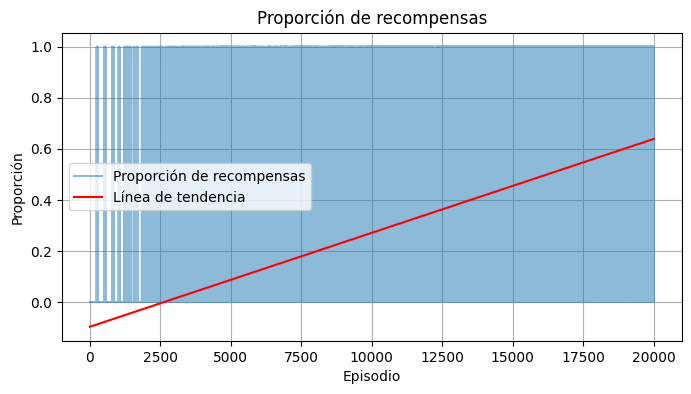

In [15]:
plot(rewards_per_episode_mc_on)  # Pass only rewards_per_episode

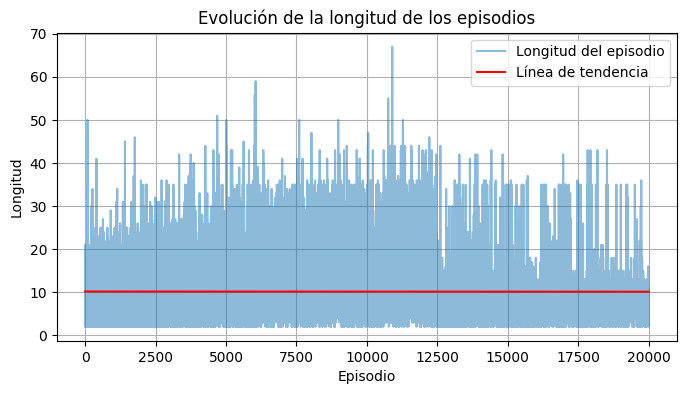

In [16]:
plot_episode_lengths(episodes_sizes_mc_on)

In [17]:
# Extraer la política óptima para todos los estados
optimal_policy_vector = np.argmax(agent.Q, axis=1)
print("Política óptima (vector de acciones):\n", optimal_policy_vector)

# Evaluar la política en un episodio de prueba
action_log, frames_recorded = evaluate_policy(env_mc_on, optimal_policy_vector, seed=seed)
print("\nAcciones tomadas en la evaluación:\n", action_log)
print("\nGrid del entorno:\n", env_mc_on.render())


Política óptima (vector de acciones):
 [2 3 0 0 2 0 0 0 3 2 2 0 0 2 2 0]

Acciones tomadas en la evaluación:
 [2, 2, 3, 3, 3, 2, 2, 2, 2, 2]

Grid del entorno:
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]


In [18]:
video_dir = record_policy_with_fn(optimal_policy_fn, env=env_mc_on, video_dir="videos_mc_on")
latest_video_file = get_latest_episode_video_file(video_dir)
print("Video grabado:", latest_video_file)
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_mc_on folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_mc_on/rl-video-episode-20000.mp4


## OFF policy

In [19]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

env_mc_off = gym.make("FrozenLake-v1", render_mode="rgb_array")
env_mc_off = gym.wrappers.RecordVideo(env_mc_off, video_folder="videos_mc_off")

# Hiperparámetros
NUM_EPISODES = 20000
GAMMA = 0.99       # Factor de descuento
EPSILON = 1.0      # Probabilidad de exploración
EPSILON_DECAY = 0.9999
MIN_EPSILON = 0.002

# Clase MonteCarloOffPolicyAgent
class MonteCarloOffPolicyAgent:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializamos Q y la suma de pesos acumulados C para cada par (estado, acción)
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.C = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: acción greedy según Q

    # Actualizar la tabla Q usando Monte Carlo Off-Policy con muestreo por importancia ponderado
    def update(self, episode):
        G = 0  # Retorno acumulado
        W = 1  # Peso acumulado de importance sampling
        n_actions = self.env.action_space.n  # Número de acciones

        # Recorrer el episodio en reversa
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward

            # Acumular el peso para el par (state, action)
            self.C[state, action] += W
            # Actualización incremental de Q(s,a) con la suma acumulada de pesos
            self.Q[state, action] += (W / self.C[state, action]) * (G - self.Q[state, action])

            # Si la acción tomada no es la acción greedy según la política target, terminamos la actualización
            if action != np.argmax(self.Q[state]):
                break

            # Calcular la probabilidad de tomar la acción greedy bajo la política comportamiento
            b_prob = (1 - self.epsilon) + (self.epsilon / n_actions)
            # Actualizar el peso W usando la relación de importancia
            W = W * (1.0 / b_prob)

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)


In [20]:
# Inicializar el agente
agent = MonteCarloOffPolicyAgent(
    env=env_mc_off,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_mc_off = []
episodes_sizes_mc_off = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_mc_off.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env_mc_off.step(action)

        # Guardar datos del episodio
        episode_data.append((obs, action, reward))

        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Actualizar el agente con el episodio completo
    agent.update(episode_data)

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_mc_off.append(episode_reward)
    episodes_sizes_mc_off.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

# Cerrar el entorno
env_mc_off.close()

 12%|█▏        | 2323/20000 [00:01<00:06, 2762.10it/s]

Éxito promedio: 0.0145, Épsilon: 0.8186406930090225


 22%|██▏       | 4398/20000 [00:01<00:05, 2971.02it/s]

Éxito promedio: 0.02525, Épsilon: 0.6702396082111141


 32%|███▏      | 6428/20000 [00:02<00:04, 3101.98it/s]

Éxito promedio: 0.0305, Épsilon: 0.548740291377179


 42%|████▏     | 8420/20000 [00:03<00:03, 2912.66it/s]

Éxito promedio: 0.041875, Épsilon: 0.4492660590208893


 51%|█████▏    | 10289/20000 [00:03<00:03, 2755.24it/s]

Éxito promedio: 0.0612, Épsilon: 0.3678242603283259


 61%|██████    | 12190/20000 [00:04<00:03, 2555.22it/s]

Éxito promedio: 0.0855, Épsilon: 0.3011460219829101


 72%|███████▏  | 14408/20000 [00:05<00:02, 2693.73it/s]

Éxito promedio: 0.11685714285714285, Épsilon: 0.24655504363736244


 81%|████████▏ | 16286/20000 [00:06<00:01, 2593.27it/s]

Éxito promedio: 0.1486875, Épsilon: 0.20186017780594118


 93%|█████████▎| 18571/20000 [00:06<00:00, 2906.83it/s]

Éxito promedio: 0.18233333333333332, Épsilon: 0.16526748259824006


100%|██████████| 20000/20000 [00:07<00:00, 2590.62it/s]


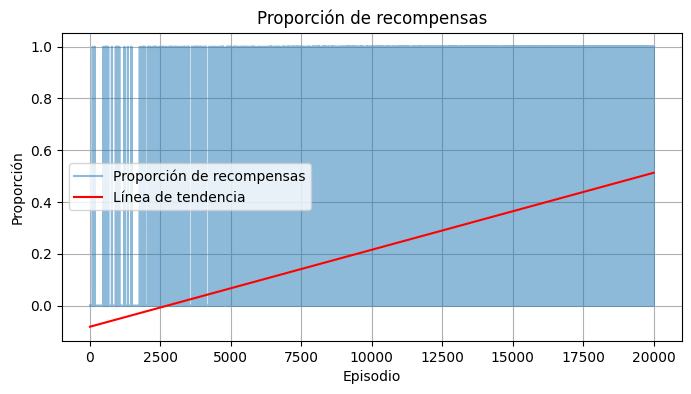

In [21]:
plot(rewards_per_episode_mc_off)  # Pass only rewards_per_episode

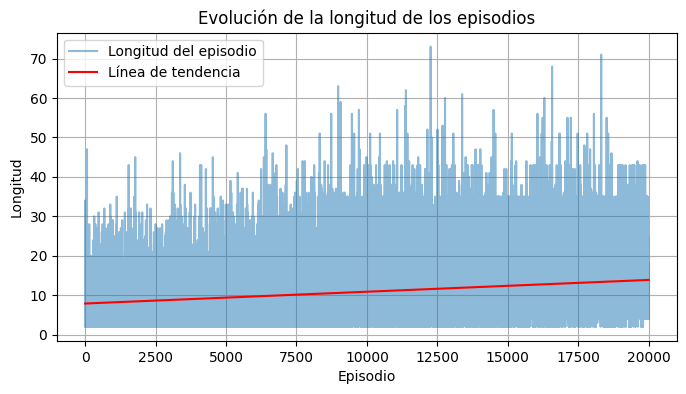

In [22]:
plot_episode_lengths(episodes_sizes_mc_off)

In [23]:
# Extraer la política óptima para todos los estados
optimal_policy_vector = np.argmax(agent.Q, axis=1)
print("Política óptima (vector de acciones):\n", optimal_policy_vector)

# Evaluar la política en un episodio de prueba
action_log, frames_recorded = evaluate_policy(env_mc_off, optimal_policy_vector, seed=seed)
print("\nAcciones tomadas en la evaluación:\n", action_log)
print("\nGrid del entorno:\n", env_mc_on.render())

Política óptima (vector de acciones):
 [3 3 0 0 2 0 0 0 3 2 1 0 0 2 2 0]

Acciones tomadas en la evaluación:
 [3, 3, 0, 0, 1, 2, 2, 2, 2, 2]

Grid del entorno:
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]


In [24]:
video_dir = record_policy_with_fn(optimal_policy_fn, env=env_mc_off, video_dir="videos_mc_off")
latest_video_file = get_latest_episode_video_file(video_dir)
print("Video grabado:", latest_video_file)
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_mc_off folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_mc_off/rl-video-episode-20000.mp4


Comparación

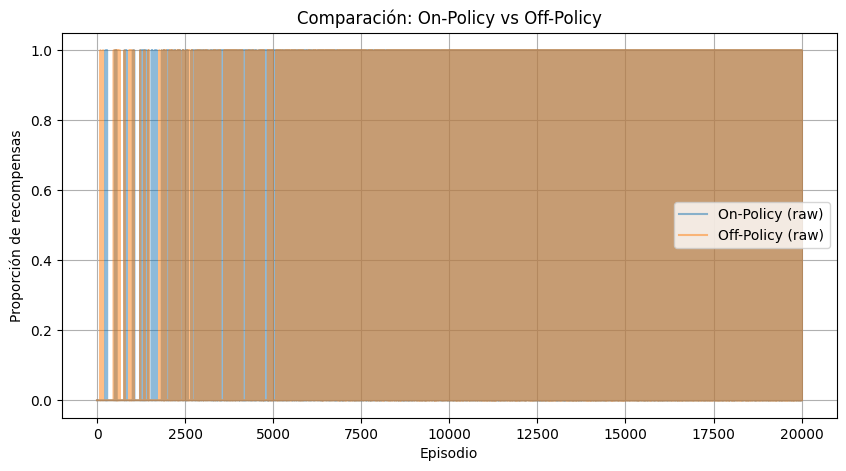

In [25]:
plot_comparison(rewards_per_episode_mc_on, rewards_per_episode_mc_off)

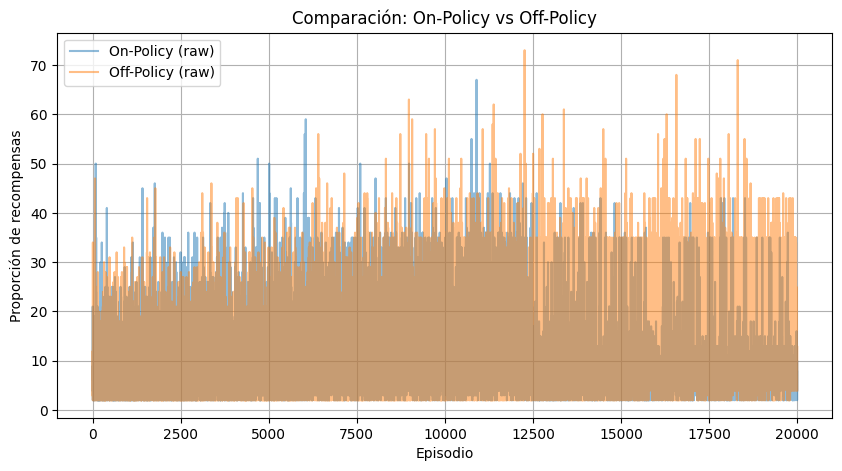

In [26]:
plot_comparison(episodes_sizes_mc_on, episodes_sizes_mc_off)

# **Diferencias Temporales**

In [27]:
# Clase SARSA Agent
class SARSAAgent:
    def __init__(self, env, gamma, alpha, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración
        else:
            return np.argmax(self.Q[state])  # Explotación

    def update(self, state, action, reward, next_state, next_action, done):
        target = reward + (0 if done else self.gamma * self.Q[next_state, next_action])
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

# Clase Q-Learning Agent
class QLearningAgent:
    def __init__(self, env, gamma, alpha, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración
        else:
            return np.argmax(self.Q[state])  # Explotación

    def update(self, state, action, reward, next_state, done):
        target = reward + (0 if done else self.gamma * np.max(self.Q[next_state]))
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

In [28]:
# Crear un nuevo entorno con grabación de video
env_sarsa = gym.make("FrozenLake-v1", render_mode="rgb_array")
env_sarsa = gym.wrappers.RecordVideo(env_sarsa, video_folder="videos_sarsa")

agent = SARSAAgent(
    env=env_sarsa,
    gamma=GAMMA,
    alpha=0.1,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_sarsa = []
episodes_sizes_sarsa = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_sarsa.reset(seed=seed)
    action = agent.get_action(obs)  # SARSA necesita elegir la acción antes de empezar el episodio
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        next_obs, reward, terminated, truncated, info = env_sarsa.step(action)
        done = terminated or truncated
        next_action = agent.get_action(next_obs) if not done else None

        # Actualizar SARSA en cada paso
        agent.update(obs, action, reward, next_obs, next_action, done)

        # Actualizar estado y métricas
        obs, action = next_obs, next_action
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_sarsa.append(episode_reward)
    episodes_sizes_sarsa.append(episode_steps)

    # Para mostrar la evolución
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")


 13%|█▎        | 2572/20000 [00:01<00:05, 3165.38it/s]

Éxito promedio: 0.2185, Épsilon: 0.16559836487980828


 23%|██▎       | 4511/20000 [00:02<00:04, 3582.42it/s]

Éxito promedio: 0.5195, Épsilon: 0.01582273706228526


 33%|███▎      | 6628/20000 [00:02<00:03, 3854.55it/s]

Éxito promedio: 0.674, Épsilon: 0.002


 42%|████▏     | 8369/20000 [00:03<00:03, 3512.44it/s]

Éxito promedio: 0.75525, Épsilon: 0.002


 53%|█████▎    | 10614/20000 [00:03<00:02, 4019.99it/s]

Éxito promedio: 0.8029, Épsilon: 0.002


 62%|██████▏   | 12373/20000 [00:04<00:02, 3695.73it/s]

Éxito promedio: 0.8353333333333334, Épsilon: 0.002


 75%|███████▍  | 14914/20000 [00:04<00:01, 4507.56it/s]

Éxito promedio: 0.8583571428571428, Épsilon: 0.002


 82%|████████▏ | 16456/20000 [00:05<00:00, 4287.56it/s]

Éxito promedio: 0.87525, Épsilon: 0.002


 92%|█████████▏| 18468/20000 [00:05<00:00, 4433.95it/s]

Éxito promedio: 0.8887777777777778, Épsilon: 0.002


100%|██████████| 20000/20000 [00:05<00:00, 3405.84it/s]


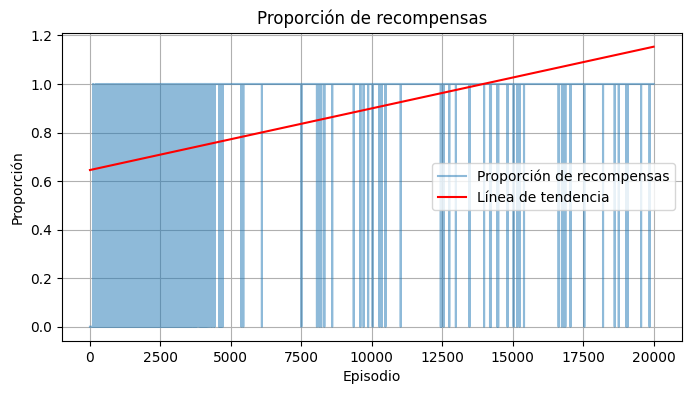

In [29]:
plot(rewards_per_episode_sarsa)  # Pass only rewards_per_episode

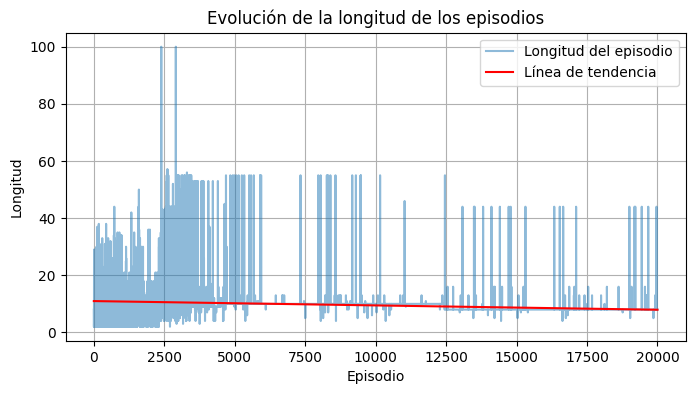

In [30]:
plot_episode_lengths(episodes_sizes_sarsa)

In [31]:
# Primero, evaluamos la política óptima usando la Q del agente
optimal_policy, action_log, frames_recorded = optimal_policy_from_q(env_sarsa, agent.Q)

# Mostramos los resultados
print("Política óptima obtenida:\n", optimal_policy)
print("\nAcciones tomadas:\n", action_log)
print("\nGrid del entorno:\n", env_sarsa.render())

Política óptima obtenida:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 3.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 3.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]]

Acciones tomadas:
 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 3, 2, 1, 2, 

Grid del entorno:
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180

In [32]:
# Definimos la función de política GREEDY a partir de la Q del agente
def greedy_policy(state):
    import numpy as np
    return np.argmax(agent.Q[state])

In [33]:
video_dir = record_policy_with_fn(greedy_policy, env=env_sarsa, video_dir="videos_sarsa")
latest_video_file = get_latest_episode_video_file(video_dir)
print("Video grabado:", latest_video_file)
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_sarsa folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_sarsa/rl-video-episode-20000.mp4


In [34]:
env_qlearning = gym.make("FrozenLake-v1", render_mode="rgb_array")
env_qlearning = gym.wrappers.RecordVideo(env_qlearning, video_folder="videos_qlearning")

agent = QLearningAgent(
    env=env_qlearning,
    gamma=GAMMA,
    alpha=0.1,
    epsilon=EPSILON,
    epsilon_decay=0.9995,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_ql = []
episodes_sizes_ql = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_qlearning.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        action = agent.get_action(obs)  # Se elige la acción aquí en cada paso
        next_obs, reward, terminated, truncated, info = env_qlearning.step(action)
        done = terminated or truncated

        agent.update(obs, action, reward, next_obs, done)

        # Actualizar estado y métricas
        obs = next_obs
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_ql.append(episode_reward)
    episodes_sizes_ql.append(episode_steps)

    # Para mostrar la evolución
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

 11%|█         | 2186/20000 [00:01<00:08, 2144.25it/s]

Éxito promedio: 0.772, Épsilon: 0.002


 21%|██▏       | 4265/20000 [00:02<00:06, 2281.10it/s]

Éxito promedio: 0.88375, Épsilon: 0.002


 32%|███▏      | 6353/20000 [00:03<00:04, 3364.17it/s]

Éxito promedio: 0.9188333333333333, Épsilon: 0.002


 42%|████▏     | 8357/20000 [00:03<00:03, 3591.58it/s]

Éxito promedio: 0.936625, Épsilon: 0.002


 51%|█████     | 10175/20000 [00:05<00:07, 1264.21it/s]

Éxito promedio: 0.9445, Épsilon: 0.002


 60%|██████    | 12050/20000 [00:06<00:07, 1080.88it/s]

Éxito promedio: 0.95125, Épsilon: 0.002


 70%|███████   | 14032/20000 [00:08<00:06, 918.37it/s] 

Éxito promedio: 0.9553571428571429, Épsilon: 0.002


 80%|████████  | 16075/20000 [00:10<00:03, 992.93it/s] 

Éxito promedio: 0.957875, Épsilon: 0.002


 91%|█████████ | 18118/20000 [00:11<00:01, 1055.29it/s]

Éxito promedio: 0.9591666666666666, Épsilon: 0.002


100%|██████████| 20000/20000 [00:15<00:00, 1307.44it/s]


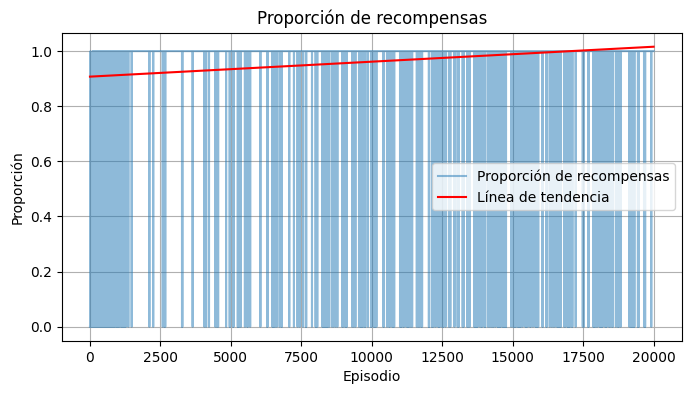

In [35]:
plot(rewards_per_episode_ql)  # Pass only rewards_per_episode

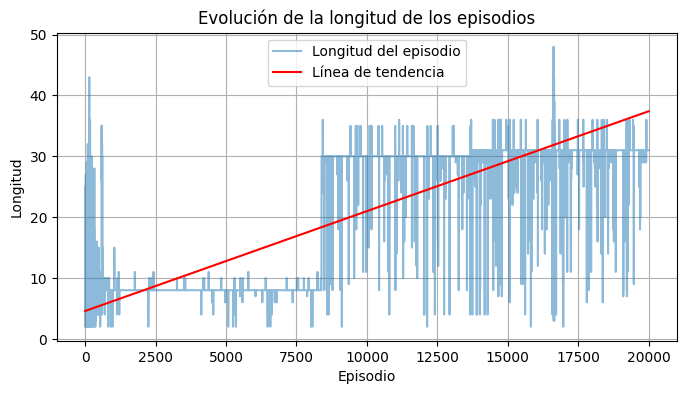

In [36]:
plot_episode_lengths(episodes_sizes_ql)

In [37]:
# Primero, evaluamos la política óptima usando la Q del agente
optimal_policy, action_log, frames_recorded = optimal_policy_from_q(env_qlearning, agent.Q)

# Mostramos los resultados
print("Política óptima obtenida:\n", optimal_policy)
print("\nAcciones tomadas:\n", action_log)
print("\nGrid del entorno:\n", env_qlearning.render())

Política óptima obtenida:
 [[0. 0. 0. 3.]
 [0. 0. 0. 3.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Acciones tomadas:
 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 2, 

Grid del entorno:
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]


In [38]:
video_dir = record_policy_with_fn(greedy_policy, env=env_qlearning, video_dir="videos_qlearning")
latest_video_file = get_latest_episode_video_file(video_dir)
print("Video grabado:", latest_video_file)
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_qlearning folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_qlearning/rl-video-episode-20000.mp4


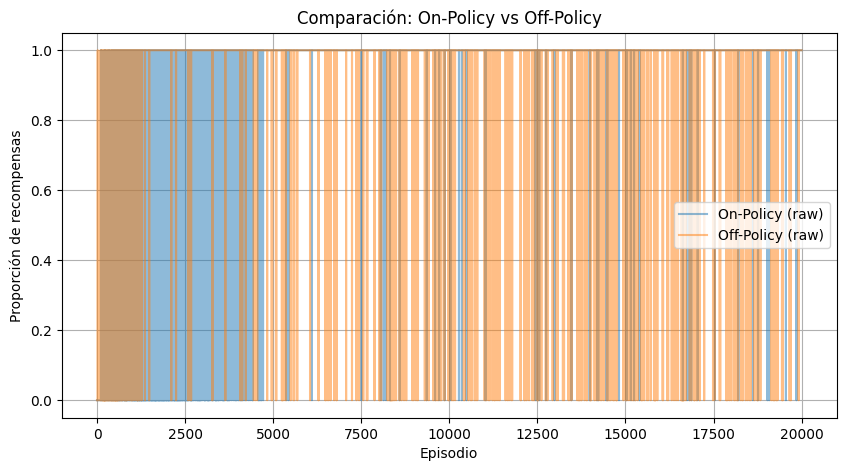

In [39]:
plot_comparison(rewards_per_episode_sarsa, rewards_per_episode_ql)

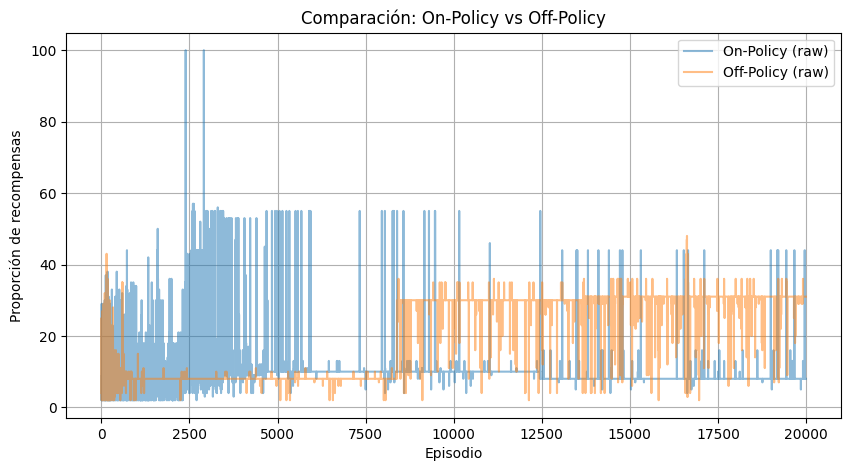

In [40]:
plot_comparison(episodes_sizes_sarsa, episodes_sizes_ql)

# **Control Con Aproximaciones**

## SARSA Semi-Gradiente

In [41]:
class SARSASemiGradient:
    def __init__(self, env, alpha=0.01, gamma=0.99, epsilon=1.0, epsilon_decay=0.9999, min_epsilon=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializar pesos w con valores pequeños
        self.w = np.random.rand(env.observation_space.n, env.action_space.n) * 0.01

    def featurize_state_action(self, state, action):
        """Codificación simple de estado-acción como one-hot vector"""
        features = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        features[state, action] = 1
        return features

    def q_value(self, state, action):
        """Calcula Q(s,a) como w^T * x(s,a)"""
        features = self.featurize_state_action(state, action)
        return np.sum(self.w * features)

    def get_action(self, state):
        """Política epsilon-greedy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración
        else:
            return np.argmax([self.q_value(state, a) for a in range(self.env.action_space.n)])  # Explotación

    def update(self, state, action, reward, next_state, next_action, done):
        """Actualización de pesos w con semi-gradiente"""
        features = self.featurize_state_action(state, action)
        target = reward + (0 if done else self.gamma * self.q_value(next_state, next_action))
        error = target - self.q_value(state, action)
        self.w += self.alpha * error * features  # Gradiente ascendente

        # Reducir epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

In [42]:
# Crear entorno con grabación de video
env_sarsa_sg = gym.make("FrozenLake-v1", render_mode="rgb_array")
env_sarsa_sg = gym.wrappers.RecordVideo(env_sarsa_sg, video_folder="videos_sarsa_sg")

# Inicializar el agente SARSA Semi-Gradiente
agent = SARSASemiGradient(
    env=env_sarsa_sg,
    alpha=0.01,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_sarsa_sg = []
episodes_sizes_sarsa_sg = []

# Para mostrar la evolución en consola
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_sarsa_sg.reset(seed=seed)
    action = agent.get_action(obs)
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        next_obs, reward, terminated, truncated, info = env_sarsa_sg.step(action)
        done = terminated or truncated
        next_action = agent.get_action(next_obs) if not done else None

        agent.update(obs, action, reward, next_obs, next_action, done)

        # Actualizar estado y métricas
        obs, action = next_obs, next_action
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_sarsa_sg.append(episode_reward)
    episodes_sizes_sarsa_sg.append(episode_steps)

    # Mostrar información de progreso
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

print("Entrenamiento de SARSA Semi-Gradiente completado.")

 10%|█         | 2099/20000 [00:02<00:14, 1198.88it/s]

Éxito promedio: 0.197, Épsilon: 0.13757319426078232


 21%|██▏       | 4269/20000 [00:03<00:10, 1476.03it/s]

Éxito promedio: 0.49675, Épsilon: 0.02382578568963034


 31%|███       | 6187/20000 [00:04<00:10, 1377.14it/s]

Éxito promedio: 0.6493333333333333, Épsilon: 0.004689786955255197


 40%|████      | 8086/20000 [00:06<00:10, 1174.48it/s]

Éxito promedio: 0.734875, Épsilon: 0.002


 51%|█████     | 10202/20000 [00:08<00:09, 1023.33it/s]

Éxito promedio: 0.7867, Épsilon: 0.002


 61%|██████    | 12165/20000 [00:09<00:05, 1429.45it/s]

Éxito promedio: 0.8211666666666667, Épsilon: 0.002


 71%|███████   | 14123/20000 [00:11<00:04, 1366.11it/s]

Éxito promedio: 0.8450714285714286, Épsilon: 0.002


 81%|████████  | 16145/20000 [00:12<00:02, 1460.57it/s]

Éxito promedio: 0.86325, Épsilon: 0.002


 91%|█████████ | 18193/20000 [00:13<00:01, 1553.16it/s]

Éxito promedio: 0.8772222222222222, Épsilon: 0.002


100%|██████████| 20000/20000 [00:14<00:00, 1339.40it/s]

Entrenamiento de SARSA Semi-Gradiente completado.


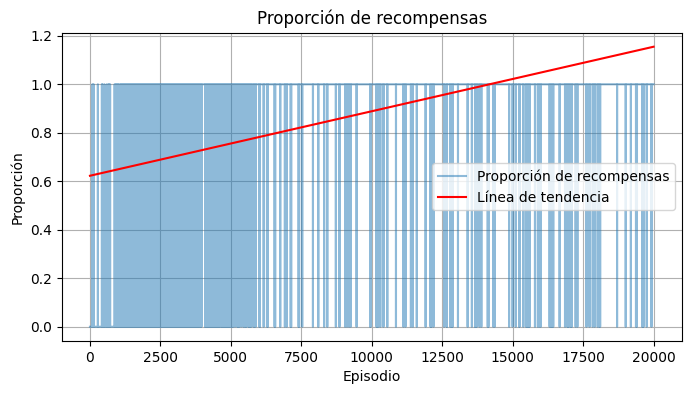

In [43]:
plot(rewards_per_episode_sarsa_sg)  # Pass only rewards_per_episode

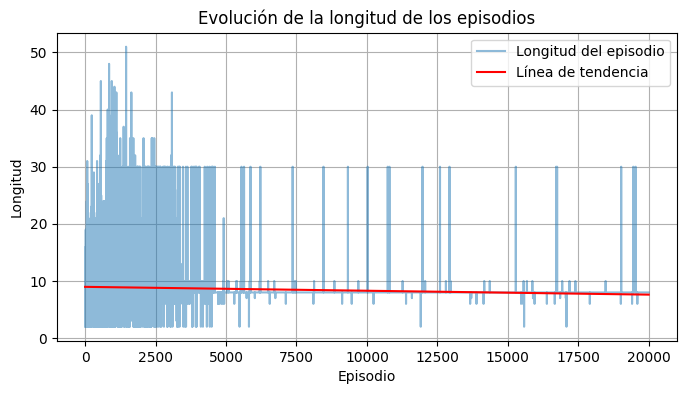

In [44]:
plot_episode_lengths(episodes_sizes_sarsa_sg)

In [45]:
def optimal_policy_from_q(env, agent):
    """Evalúa la política óptima aprendida a partir de los valores de Q estimados por SARSA SG."""
    optimal_policy = np.zeros(env.observation_space.n, dtype=int)
    action_log = []
    frames = []

    for state in range(env.observation_space.n):
        optimal_policy[state] = np.argmax([agent.q_value(state, a) for a in range(env.action_space.n)])

    # Simulación de la política óptima
    state, _ = env.reset(seed=seed)
    done = False

    while not done:
        frames.append(env.render())  # Guardar la imagen del entorno
        action = optimal_policy[state]
        action_log.append(action)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    return optimal_policy, action_log, frames

In [46]:
# Primero, evaluamos la política óptima usando la Q del agente
optimal_policy, action_log, frames_recorded = optimal_policy_from_q(env_sarsa_sg, agent)

# Mostramos los resultados
print("Política óptima obtenida:\n", optimal_policy)
print("\nAcciones tomadas:\n", action_log)
print("\nGrid del entorno:\n", env_qlearning.render())

Política óptima obtenida:
 [3 3 2 3 0 3 2 3 3 2 2 1 2 3 2 1]

Acciones tomadas:
 [3, 3, 2, 2, 2, 2, 2, 2]

Grid del entorno:
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]


In [47]:
def greedy_policy_sarsa_sg(state, agent):
    """Selecciona la acción óptima para SARSA Semi-Gradiente usando la función aproximadora."""
    return np.argmax([agent.q_value(state, a) for a in range(agent.env.action_space.n)])

In [48]:
def record_policy_with_fn_SarsaDQL(policy_fn, agent, env, num_episodes=1, video_dir="videos"):
    """Graba un video ejecutando una política greedy sin exploración."""
    os.makedirs(video_dir, exist_ok=True)

    env = gym.wrappers.RecordVideo(env, video_folder=video_dir, episode_trigger=lambda ep: ep == 0)

    state, _ = env.reset(seed=seed)
    done = False

    while not done:
        action = policy_fn(state, agent)  # Aplicar la política óptima aprendida
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()

    return video_dir


In [49]:
# Grabar el video con la mejor política aprendida
video_dir = record_policy_with_fn_SarsaDQL(greedy_policy_sarsa_sg, agent, env_sarsa_sg, video_dir="videos_sarsa_sg")

# Obtener el último video grabado
latest_video_file = get_latest_episode_video_file(video_dir)

# Mostrar información del video grabado
print("Video grabado:", latest_video_file)

# Mostrar el video en el notebook
embed_video(latest_video_file)

Video grabado: videos_sarsa_sg/rl-video-episode-20000.mp4


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos_sarsa_sg folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## Deep Q-Learning

In [50]:
import torch.optim as optim
import torch.nn as nn
import torch
import random

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # No activación final (Q-values)

In [51]:
class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.9995, min_epsilon=0.01, batch_size=32, target_update_freq=100):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq  # Cada cuántos pasos actualizamos la target_network

        # Red principal y Red Objetivo
        self.model = DQN(env.observation_space.n, env.action_space.n)
        self.target_network = DQN(env.observation_space.n, env.action_space.n)
        self.target_network.load_state_dict(self.model.state_dict())  # Inicializar con los mismos pesos

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)
        self.criterion = nn.MSELoss()

        self.replay_buffer = []  # Buffer de memoria para Experience Replay
        self.steps = 0  # Contador de pasos totales

    def get_action(self, state):
        """Estrategia epsilon-greedy para elegir acción."""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración

        # Convertir el estado a representación one-hot
        state_tensor = torch.tensor(np.eye(self.env.observation_space.n)[state], dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            q_values = self.model(state_tensor)  # Obtener valores Q

        return torch.argmax(q_values, dim=1).item()  # Seleccionar la mejor acción

    def update(self, state, action, reward, next_state, done):
        """Guarda la experiencia y entrena con un minibatch."""
        self.replay_buffer.append((state, action, reward, next_state, done))

        if len(self.replay_buffer) < self.batch_size:  # Esperar hasta que haya suficientes datos
            return

        # Seleccionar un minibatch de experiencias
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # **Corrección: Indexar `np.eye()` correctamente**
        states = torch.tensor(np.eye(self.env.observation_space.n)[list(states)], dtype=torch.float32)
        next_states = torch.tensor(np.eye(self.env.observation_space.n)[list(next_states)], dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Calcular Q-target con la red objetivo
        with torch.no_grad():
            target_q_values = rewards + (1 - dones) * self.gamma * torch.max(self.target_network(next_states), dim=1)[0]

        # Calcular Q actual de la red principal
        q_values = self.model(states).gather(1, torch.tensor(actions, dtype=torch.long).unsqueeze(1)).squeeze()

        # Calcular pérdida y actualizar pesos
        loss = self.criterion(q_values, target_q_values.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Cada ciertos pasos actualizamos la red objetivo
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.model.state_dict())

In [52]:
# Inicializar entorno con grabación de video cada 100 episodios
env_dqn = gym.make("FrozenLake-v1", render_mode="rgb_array")
env_dqn = gym.wrappers.RecordVideo(env_dqn, video_folder="videos_dqn", episode_trigger=lambda ep: ep % 100 == 0)

# Inicializar el agente DQN
agent = DQNAgent(
    env=env_dqn,
    alpha=0.001,  # Learning rate bajo para redes neuronales
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.9995,
    min_epsilon=0.01
)

# Definir variables de entrenamiento
NUM_EPISODES = 20000
rewards_per_episode_dqn = []
episodes_sizes_dqn = []

stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Entrenamiento del DQN
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_dqn.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        action = agent.get_action(obs)  # Se elige la acción en cada paso
        next_obs, reward, terminated, truncated, info = env_dqn.step(action)
        done = terminated or truncated

        agent.update(obs, action, reward, next_obs, done)

        # Actualizar estado y métricas
        obs = next_obs
        episode_reward += reward
        episode_steps += 1

    # Guardar métricas del episodio
    stats += episode_reward
    list_stats.append(stats / (episode + 1))
    rewards_per_episode_dqn.append(episode_reward)
    episodes_sizes_dqn.append(episode_steps)

    # Reducir epsilon gradualmente
    agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)

    # Mostrar información de progreso
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

print("Entrenamiento de Deep Q-Learning completado.")


 10%|█         | 2005/20000 [00:39<10:17, 29.16it/s]

Éxito promedio: 0.0795, Épsilon: 0.36760355841993914


 20%|██        | 4005/20000 [01:45<08:43, 30.57it/s]

Éxito promedio: 0.193, Épsilon: 0.1351999761510762


 30%|███       | 6003/20000 [02:55<07:57, 29.30it/s]

Éxito promedio: 0.35383333333333333, Épsilon: 0.04972485475880578


 40%|████      | 8004/20000 [04:01<05:39, 35.36it/s]

Éxito promedio: 0.48375, Épsilon: 0.018288177640071544


 50%|█████     | 10008/20000 [04:58<04:06, 40.49it/s]

Éxito promedio: 0.5734, Épsilon: 0.01


 60%|██████    | 12005/20000 [05:52<04:53, 27.28it/s]

Éxito promedio: 0.6356666666666667, Épsilon: 0.01


 70%|███████   | 14007/20000 [06:45<02:37, 37.94it/s]

Éxito promedio: 0.681, Épsilon: 0.01


 80%|███████▉  | 15999/20000 [07:36<01:48, 36.89it/s]

Éxito promedio: 0.7158125, Épsilon: 0.01


 90%|█████████ | 18001/20000 [08:27<01:00, 33.07it/s]

Éxito promedio: 0.7426666666666667, Épsilon: 0.01


100%|██████████| 20000/20000 [09:17<00:00, 35.90it/s]

Entrenamiento de Deep Q-Learning completado.


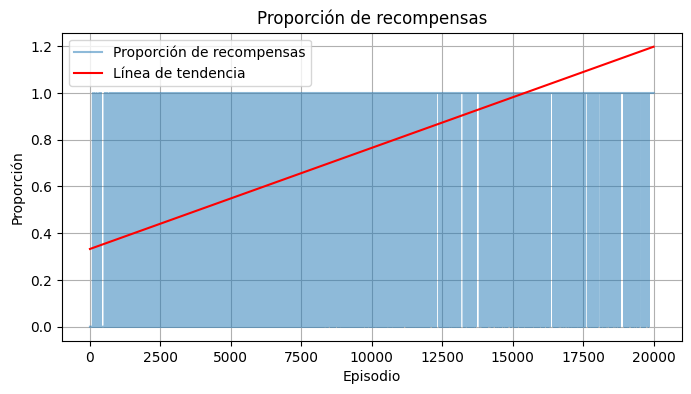

In [53]:
plot(rewards_per_episode_dqn)  # Pass only rewards_per_episode

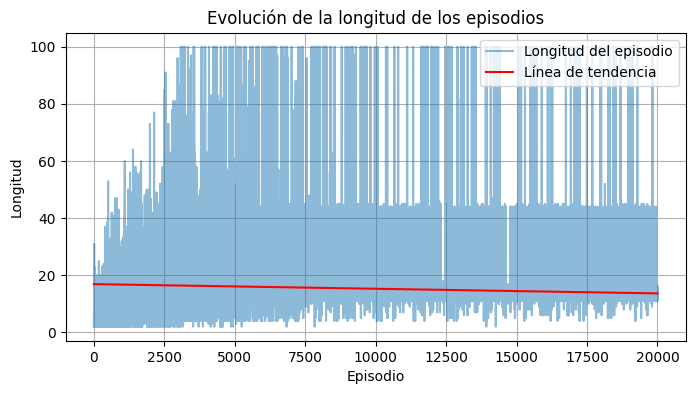

In [54]:
plot_episode_lengths(episodes_sizes_dqn)

In [55]:
def optimal_policy_from_dqn(env, agent):
    """Evalúa la política óptima aprendida a partir de los valores de Q estimados por la red neuronal en DQN."""
    optimal_policy = np.zeros(env.observation_space.n, dtype=int)
    action_log = []
    frames = []

    for state in range(env.observation_space.n):
        # Predecir Q(s,a) con la red neuronal y elegir la mejor acción
        state_tensor = torch.tensor(np.eye(env.observation_space.n)[state], dtype=torch.float32)
        optimal_policy[state] = torch.argmax(agent.model(state_tensor)).item()

    # Simulación de la política óptima
    state, _ = env.reset(seed=seed)
    done = False

    while not done:
        frames.append(env.render())  # Guardar la imagen del entorno
        action = optimal_policy[state]
        action_log.append(action)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    return optimal_policy, action_log, frames


In [56]:
# Evaluar la política óptima aprendida por Deep Q-Learning
optimal_policy_dqn, action_log_dqn, frames_dqn = optimal_policy_from_dqn(env_dqn, agent)

# Mostrar resultados
print("Política óptima obtenida en DQN:\n", optimal_policy_dqn)
print("\nAcciones tomadas:\n", action_log_dqn)
print("\nGrid del entorno:\n", env_dqn.render())  # Mostrar el entorno de DQN


Política óptima obtenida en DQN:
 [0 3 0 3 0 0 2 0 3 1 1 0 1 2 1 0]

Acciones tomadas:
 [0, 0, 0, 0, 3, 1, 3, 1, 2, 2, 1, 1, 2, 1, 2, 1]

Grid del entorno:
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]


In [57]:
def greedy_policy_dqn(state, agent):
    """Selecciona la acción óptima para DQN usando la red neuronal."""
    state_tensor = torch.tensor(np.eye(agent.env.observation_space.n)[state], dtype=torch.float32)
    return torch.argmax(agent.model(state_tensor)).item()

In [58]:
# Grabar el video con la mejor política aprendida
video_dir = record_policy_with_fn_SarsaDQL(greedy_policy_dqn, agent, env_dqn, video_dir="videos_dqn")

# Obtener el último video grabado
latest_video_file = get_latest_episode_video_file(video_dir)

# Mostrar información del video grabado
print("Video grabado:", latest_video_file)

# Mostrar el video en el notebook
embed_video(latest_video_file)


Video grabado: videos_dqn/rl-video-episode-20000.mp4


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos_dqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


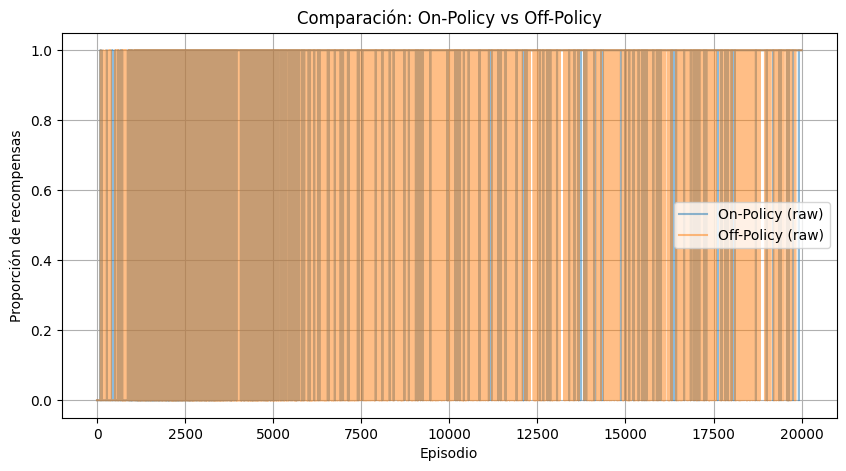

In [59]:
plot_comparison(rewards_per_episode_sarsa_sg, rewards_per_episode_dqn)

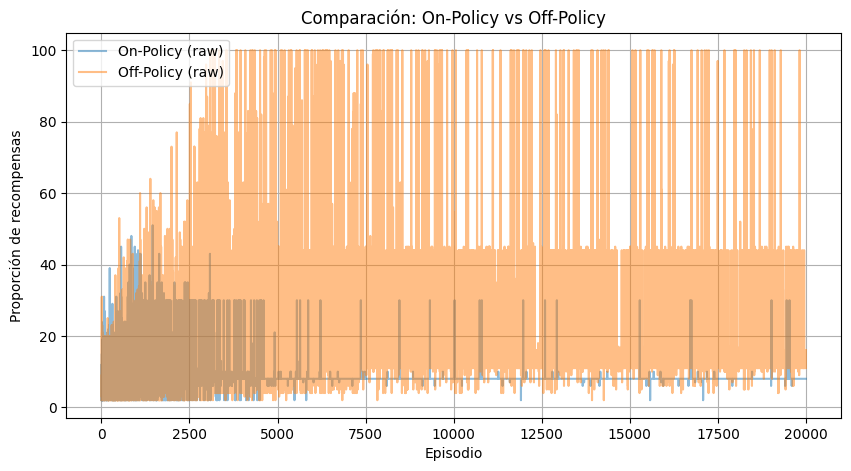

In [60]:
plot_comparison(episodes_sizes_sarsa_sg, episodes_sizes_dqn)